# 3D FEA — scikit-fem (Extruded Geometry)

Full 3D finite element analysis of the CCS bistable beam using `scikit-fem`.

The beam polygon is extruded by the structural thickness (0.5 µm) in the z-direction
using `gmsh`. No plane strain assumption — full 3D elasticity.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

import gmsh
import meshio
import skfem
from skfem import *
from skfem.models.elasticity import linear_elasticity, lame_parameters
from skfem.helpers import dot, ddot, sym_grad, transpose, eye, grad, det, inv

sys.path.insert(0, os.path.dirname(os.path.abspath("__file__")))
from beam_utils import (
    POLY_SI, DEFAULT_BEAM_PARAMS, get_beam_polygon,
    get_beam_centerline,
)

L = DEFAULT_BEAM_PARAMS["span"]
h = DEFAULT_BEAM_PARAMS["initial_offset"]
t = POLY_SI["t"]
E = POLY_SI["E"]
nu = POLY_SI["nu"]
lam, mu = lame_parameters(E, nu)
print(f"E={E/1e3:.0f} GPa, ν={nu}, λ={lam:.1f} MPa, μ={mu:.1f} MPa")

E=160 GPa, ν=0.22, λ=51522.2 MPa, μ=65573.8 MPa


## 1. 3D Mesh Generation with gmsh

In [2]:
poly = get_beam_polygon(n_points=300)
if np.allclose(poly[0], poly[-1]):
    poly = poly[:-1]

gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 0)  # suppress output
gmsh.model.add("ccs_beam_3d")

# Create polygon outline as gmsh points + lines
lc_flex = 0.15   # mesh size in flex regions
lc_rigid = 0.3   # mesh size in rigid regions

# Determine per-point mesh size based on x-position
L_flex = DEFAULT_BEAM_PARAMS["flex_ratio"] * L / 2.0

point_tags = []
for i, (x, y) in enumerate(poly):
    # Finer mesh in flex regions
    in_flex = (x < L_flex + 1) or (x > L - L_flex - 1)
    lc = lc_flex if in_flex else lc_rigid
    tag = gmsh.model.occ.addPoint(x, y, 0, lc)
    point_tags.append(tag)

# Create lines forming the closed boundary
line_tags = []
n_pts = len(point_tags)
for i in range(n_pts):
    j = (i + 1) % n_pts
    tag = gmsh.model.occ.addLine(point_tags[i], point_tags[j])
    line_tags.append(tag)

# Create wire and surface
wire = gmsh.model.occ.addCurveLoop(line_tags)
surf = gmsh.model.occ.addPlaneSurface([wire])

# Extrude by thickness
n_layers_z = 4  # 4 layers through 0.5 µm thickness
extrude = gmsh.model.occ.extrude([(2, surf)], 0, 0, t,
                                  numElements=[n_layers_z], recombine=False)

gmsh.model.occ.synchronize()

# Generate 3D mesh
gmsh.model.mesh.generate(3)

# Write to temporary file and read with meshio
tmp_msh = '/tmp/ccs_beam_3d.msh'
gmsh.write(tmp_msh)

# Get mesh stats
node_tags, coords, _ = gmsh.model.mesh.getNodes()
print(f"gmsh 3D mesh: {len(node_tags)} nodes")

gmsh.finalize()

gmsh 3D mesh: 12770 nodes


In [3]:
# Read mesh with meshio and convert to scikit-fem
msh = meshio.read(tmp_msh)

# Extract tetrahedral cells
tet_cells = None
for cell_block in msh.cells:
    if cell_block.type == 'tetra':
        tet_cells = cell_block.data
        break

if tet_cells is None:
    raise RuntimeError("No tetrahedral elements found in mesh")

points = msh.points
print(f"Mesh: {len(points)} nodes, {len(tet_cells)} tetrahedra")

# Create scikit-fem MeshTet
mesh3d = MeshTet(points.T, tet_cells.T)
print(f"scikit-fem mesh: {mesh3d.nvertices} vertices, {mesh3d.nelements} elements")

Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


Mesh: 12770 nodes, 53712 tetrahedra
scikit-fem mesh: 12770 vertices, 53712 elements


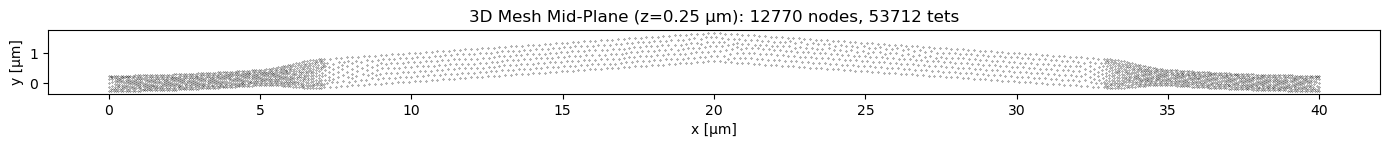

In [4]:
# Visualize mesh (xy-projection)
fig, ax = plt.subplots(figsize=(14, 4))

# Plot the mid-plane nodes
z_mid = t / 2
mid_mask = np.abs(mesh3d.p[2] - z_mid) < 0.05
ax.plot(mesh3d.p[0, mid_mask], mesh3d.p[1, mid_mask], 'k.', ms=0.5)
ax.set_aspect('equal')
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
ax.set_title(f'3D Mesh Mid-Plane (z={z_mid} µm): {mesh3d.nvertices} nodes, {mesh3d.nelements} tets')

fig.tight_layout()
fig.savefig('plots/skfem_3d_mesh.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. Boundary Identification

In [5]:
tol = 0.05

# Left anchor: x ≈ 0
left_nodes_3d = np.where(mesh3d.p[0] < tol)[0]

# Right anchor: x ≈ L
right_nodes_3d = np.where(mesh3d.p[0] > L - tol)[0]

# Center band: |x - L/2| < band
center_band = 0.2
center_nodes_3d = np.where(np.abs(mesh3d.p[0] - L/2) < center_band)[0]

print(f"Left anchor: {len(left_nodes_3d)} nodes")
print(f"Right anchor: {len(right_nodes_3d)} nodes")
print(f"Center band: {len(center_nodes_3d)} nodes")

Left anchor: 25 nodes
Right anchor: 25 nodes
Center band: 80 nodes


## 3. Linear Elasticity Sweep (3D)

In [6]:
# 3D element and basis
elem3d = ElementTetP1()  # Linear tets (P2 would be very expensive)
ib3d = Basis(mesh3d, ElementVector(elem3d))

n_dofs_scalar_3d = ib3d.Nbfun // 3
print(f"Total DOFs: {ib3d.Nbfun} ({n_dofs_scalar_3d} per component)")

# DOF mapping: [all x-DOFs, all y-DOFs, all z-DOFs]
anchor_nodes_3d = np.concatenate([left_nodes_3d, right_nodes_3d])

# Fix all 3 components at anchors
fixed_x = anchor_nodes_3d
fixed_y = anchor_nodes_3d + n_dofs_scalar_3d
fixed_z = anchor_nodes_3d + 2 * n_dofs_scalar_3d
fixed_dofs_3d = np.concatenate([fixed_x, fixed_y, fixed_z])

# Prescribe y-displacement at center
center_y_dofs_3d = center_nodes_3d + n_dofs_scalar_3d

# Assemble linear stiffness
K3d = linear_elasticity(lam, mu).assemble(ib3d)
print("Stiffness matrix assembled.")

Total DOFs: 12 (4 per component)
Stiffness matrix assembled.


In [7]:
# Linear sweep
n_disp_3d = 80
delta_3d = np.linspace(0, -2*h, n_disp_3d)
F_linear_3d = np.zeros(n_disp_3d)

for i, delta in enumerate(delta_3d):
    all_bc = np.concatenate([fixed_dofs_3d, center_y_dofs_3d])
    prescribed = np.zeros(len(all_bc))
    prescribed[len(fixed_dofs_3d):] = delta
    
    u = solve(*condense(K3d, np.zeros(ib3d.Nbfun), D=all_bc, x=prescribed))
    
    f_react = K3d @ u
    F_linear_3d[i] = np.sum(f_react[center_y_dofs_3d])
    
    if i % 20 == 0:
        print(f"  Step {i}/{n_disp_3d}: δ={delta:.3f} µm, F={F_linear_3d[i]:.4f} µN")

print("Linear 3D sweep complete.")

IndexError: index 12 is out of bounds for axis 0 with size 12

## 4. Nonlinear Sweep (3D Total Lagrangian)

In [ ]:
from skfem.assembly import BilinearForm, LinearForm

@BilinearForm
def stiffness_nl_3d(u, v, w):
    """3D tangent stiffness: Total Lagrangian, St. Venant-Kirchhoff."""
    du = grad(w['prev'])
    F = eye(du, 3) + du
    GL = 0.5 * (transpose(F) @ F - eye(du, 3))
    trE = GL[0,0] + GL[1,1] + GL[2,2]
    S = lam * trE * eye(du, 3) + 2.0 * mu * GL
    
    dv = grad(v)
    dw = grad(u)
    
    dGL = 0.5 * (transpose(F) @ dw + transpose(dw) @ F)
    trDE = dGL[0,0] + dGL[1,1] + dGL[2,2]
    dS = lam * trDE * eye(du, 3) + 2.0 * mu * dGL
    dGL_v = 0.5 * (transpose(F) @ dv + transpose(dv) @ F)
    
    k_mat = ddot(dS, dGL_v)
    k_geo = ddot(S, 0.5 * (transpose(dw) @ dv + transpose(dv) @ dw))
    return k_mat + k_geo

@LinearForm
def internal_forces_3d(v, w):
    """3D internal force vector."""
    du = grad(w['prev'])
    F = eye(du, 3) + du
    GL = 0.5 * (transpose(F) @ F - eye(du, 3))
    trE = GL[0,0] + GL[1,1] + GL[2,2]
    S = lam * trE * eye(du, 3) + 2.0 * mu * GL
    dv = grad(v)
    dGL_v = 0.5 * (transpose(F) @ dv + transpose(dv) @ F)
    return ddot(S, dGL_v)

print("3D nonlinear forms defined.")

In [ ]:
# Nonlinear sweep — fewer steps for 3D (expensive)
n_nl_3d = 100
delta_nl_3d = np.linspace(0, -2*h, n_nl_3d)
F_nl_3d = np.zeros(n_nl_3d)

u_curr_3d = np.zeros(ib3d.Nbfun)
max_newton = 40
nl_tol = 1e-6

all_bc_3d = np.concatenate([fixed_dofs_3d, center_y_dofs_3d])

for i, delta in enumerate(delta_nl_3d):
    u_iter = u_curr_3d.copy()
    u_iter[fixed_dofs_3d] = 0.0
    u_iter[center_y_dofs_3d] = delta
    
    converged = False
    for nit in range(max_newton):
        u_field = ib3d.interpolate(u_iter)
        Kt = stiffness_nl_3d.assemble(ib3d, prev=u_field)
        fint = internal_forces_3d.assemble(ib3d, prev=u_field)
        
        residual = fint.copy()
        residual[all_bc_3d] = 0.0
        
        rn = np.linalg.norm(residual)
        if rn < nl_tol:
            converged = True
            break
        
        du_c = solve(*condense(Kt, -residual, D=all_bc_3d))
        u_iter += du_c
    
    if not converged and i > 0:
        print(f"  Step {i}: δ={delta:.4f}, not converged (res={rn:.2e})")
    
    u_curr_3d = u_iter.copy()
    
    u_field = ib3d.interpolate(u_curr_3d)
    fint = internal_forces_3d.assemble(ib3d, prev=u_field)
    F_nl_3d[i] = np.sum(fint[center_y_dofs_3d])
    
    if i % 25 == 0:
        print(f"  Step {i}/{n_nl_3d}: δ={delta:.3f} µm, F={F_nl_3d[i]:.4f} µN, "
              f"Newton iters={nit+1}")

print("Nonlinear 3D sweep complete.")

## 5. Results

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(-delta_nl_3d, F_nl_3d, 'r-', linewidth=2, label='Nonlinear 3D (skfem)')
ax.plot(-delta_3d, F_linear_3d, 'b--', linewidth=1, alpha=0.5, label='Linear 3D (skfem)')

# Overlay 2D result if available
try:
    data_2d = np.loadtxt('results/skfem_2d_force_displacement.csv',
                         delimiter=',', skiprows=1)
    ax.plot(data_2d[:, 0], data_2d[:, 1], 'g:', linewidth=1.5,
            label='Nonlinear 2D (skfem)')
except FileNotFoundError:
    pass

# Overlay analytical if available
try:
    ana = np.loadtxt('results/analytical_force_displacement.csv',
                     delimiter=',', skiprows=1)
    ax.plot(ana[:, 0], ana[:, 2], 'k:', linewidth=1, label='Analytical CCS')
except FileNotFoundError:
    pass

ax.axhline(0, color='gray', linewidth=0.5)
ax.set_xlabel('Center displacement δ [µm]')
ax.set_ylabel('Force F [µN]')
ax.set_title('scikit-fem 3D — Force vs Displacement')
ax.legend()
ax.grid(True, alpha=0.3)

fig.tight_layout()
fig.savefig('plots/skfem_3d_force_displacement.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Deformed shape visualization (mid-plane)
fig, ax = plt.subplots(figsize=(14, 5))

nv = mesh3d.nvertices
ux_3d = u_curr_3d[:n_dofs_scalar_3d][:nv]
uy_3d = u_curr_3d[n_dofs_scalar_3d:2*n_dofs_scalar_3d][:nv]

# Mid-plane nodes
z_vals = mesh3d.p[2]
z_mid = t / 2
mid_mask = np.abs(z_vals - z_mid) < 0.08

ax.plot(mesh3d.p[0, mid_mask], mesh3d.p[1, mid_mask], 'k.', ms=0.3, alpha=0.3,
        label='Undeformed')
ax.plot(mesh3d.p[0, mid_mask] + ux_3d[mid_mask],
        mesh3d.p[1, mid_mask] + uy_3d[mid_mask],
        'r.', ms=0.5, label=f'Deformed (δ={2*h:.1f} µm)')

ax.set_aspect('equal')
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
ax.set_title('3D Deformed Shape (Mid-Plane Projection)')
ax.legend()

fig.tight_layout()
fig.savefig('plots/skfem_3d_deformed_shape.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Save results
np.savetxt('results/skfem_3d_force_displacement.csv',
           np.column_stack([-delta_nl_3d, F_nl_3d]),
           delimiter=',',
           header='delta_um,F_uN',
           comments='')

print("Saved: results/skfem_3d_force_displacement.csv")